In [4]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path

RANDOM_SEED = 42

# Specify each path

In [7]:
dataset_path = Path('../data/dataset')
model_path = Path('../data/model/')

for p in [dataset_path, model_path]:
    print(f'checking {p}')
    p.mkdir(exist_ok=True, parents=True)

checking ../data/dataset
checking ../data/model


In [8]:
dataset = dataset_path / 'ngt_keypoint.csv'
model_save_path = model_path / 'keypoint_classifier.keras'
tflite_save_path = model_path / 'keypoint_classifier.tflite'
# model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
# tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [9]:
NUM_CLASSES = 26

# Dataset reading

In [10]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [11]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='mish', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


2026-01-20 11:53:26.740780: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-01-20 11:53:26.740997: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-20 11:53:26.741018: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-20 11:53:26.741459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-20 11:53:26.741905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 42)                168       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                        

In [16]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    str(model_save_path), verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [17]:
# Model compilation
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


2026-01-20 11:54:17.353006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


279/279 [==============================] - ETA: 0s - loss: 2.9600 - accuracy: 0.4470
Epoch 1: saving model to ../data/model/keypoint_classifier.keras
279/279 [==============================] - 9s 23ms/step - loss: 2.9600 - accuracy: 0.4470 - val_loss: 1.8191 - val_accuracy: 0.7458
Epoch 2/1000
278/279 [============================>.] - ETA: 0s - loss: 1.6132 - accuracy: 0.7129
Epoch 2: saving model to ../data/model/keypoint_classifier.keras
279/279 [==============================] - 6s 21ms/step - loss: 1.6133 - accuracy: 0.7130 - val_loss: 1.2403 - val_accuracy: 0.8522
Epoch 3/1000
276/279 [============================>.] - ETA: 0s - loss: 1.2948 - accuracy: 0.7862
Epoch 3: saving model to ../data/model/keypoint_classifier.keras
279/279 [==============================] - 6s 21ms/step - loss: 1.2937 - accuracy: 0.7866 - val_loss: 1.0533 - val_accuracy: 0.8693
Epoch 4/1000
279/279 [==============================] - ETA: 0s - loss: 1.1361 - accuracy: 0.8216
Epoch 4: saving model to ../da

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

72/72 [==============================] - 0s 981us/step - loss: 0.7396 - accuracy: 0.8610


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 44ms/step
[3.2879745e-03 4.9783992e-08 5.1837414e-08 3.4145421e-07 1.0245185e-06
 4.7285980e-07 3.9080046e-06 8.5449139e-12 1.0444822e-03 1.7903264e-04
 7.7865288e-06 9.4868301e-05 1.2256590e-05 1.1016953e-07 1.1298443e-05
 1.2866410e-09 4.9239466e-09 1.6775457e-09 8.0287703e-07 2.3615859e-04
 9.5409358e-10 9.1225716e-10 3.6948109e-07 6.5525819e-06 9.9511248e-01
 2.5154055e-08]
24


# Confusion matrix

285/285 [==============================] - 0s 857us/step


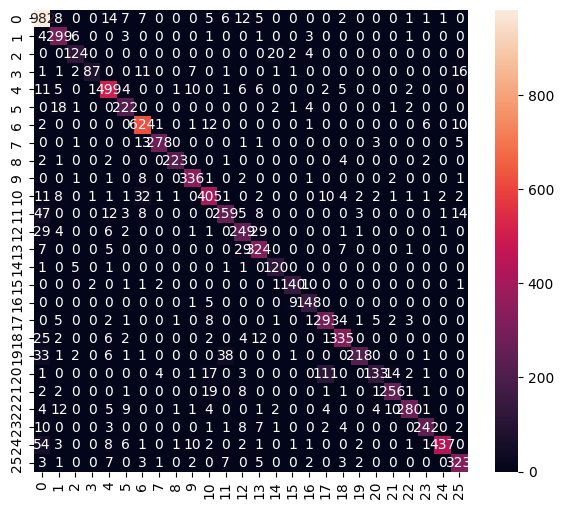

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1051
           1       0.81      0.94      0.87       318
           2       0.87      0.83      0.85       150
           3       0.96      0.68      0.79       128
           4       0.86      0.90      0.88       553
           5       0.84      0.88      0.86       251
           6       0.88      0.95      0.91       657
           7       0.97      0.92      0.94       302
           8       0.98      0.95      0.96       235
           9       0.91      0.95      0.93       353
          10       0.84      0.83      0.83       489
          11       0.82      0.72      0.77       360
          12       0.75      0.77      0.76       324
          13       0.81      0.87      0.84       373
          14       0.81      0.93      0.87       129
          15       0.90      0.89      0.89       158
          16       0.85      0.91      0.88       163
     

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpdm1xllfc\assets


INFO:tensorflow:Assets written to: C:\Users\asusg\AppData\Local\Temp\tmpdm1xllfc\assets


25176

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 4.64 ms


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.8779062e-03 4.3515342e-08 4.5718554e-08 3.0386323e-07 8.5708109e-07
 4.0149325e-07 3.5321791e-06 7.4898473e-12 9.0636604e-04 1.6149273e-04
 7.0539604e-06 9.0892005e-05 1.0583010e-05 9.3040903e-08 9.3756071e-06
 1.1751931e-09 4.5462611e-09 1.3466411e-09 6.6406932e-07 2.1929979e-04
 7.7895984e-10 7.5600248e-10 3.3496627e-07 5.4423335e-06 9.9570531e-01
 2.3175753e-08]
24
